In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from multitest import MultiTest


In [2]:
from scipy.interpolate import interp1d
import pandas as pd

In [5]:
import numpy as np
import torch
import os
#from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, GPT2LMHeadModel

# Process


### At Training
 - Decide on a model + context (or a proxy model)
 - Get data generated by the model with the relevant context
 - Evaluate log-perplexity of the data wrt to the model and the context
 - Interpolate to get an estimated survival function
 
### At inference:
 - Classifier: model, survival function, log-perplixity function (matched context policy)
 - Input: test text
 - Outputs: HC score, Fisher score, sentences
 - Reject if HC score or Fisher are large.

### What can we say:
- Test whether a document was written by a model against an alternative: "some edits"
- If we detect some edits, indicate which ones are they likely to be. We can then examine the text and apply the detector to larger chunks (e.g., to verify that the non-selected parts were indeed AI-generated).
- Determine maximal number of edits so that the text is undetectable from "AI model generated"
- Determine minimal number of edits needed so that the text cannot be reliably labeled as "entirely AI-generated" (because there exists)
- Determine the number of sentences needed to distinguish between AI-generated and AI-generated with some edits. 


# Histogram and P-values

In [74]:
def fit_pval_func(xx, G = 501):
    qq = np.linspace(0, 1, G)
    yy = [np.quantile(xx, q) for q in qq]
    return interp1d(yy, 1-qq, fill_value = (1,0), bounds_error=False)

def pval_per_sentence(texts, model, tokenizer, pval_func):
    pvals = []
    for text in texts:
        x = logloss(model, tokenizer, text)
        pval = pval_func()
        pvals.append(pval)
    return pvals

def plot_perp_vs_len(data, min_len=5, max_len=60):
    df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
    df_grouped.head()

    fig, ax = plt.subplots()
    x = df_grouped['length']
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.3)
    ax.set_ylim(ymin=0)
    ax.set_title('log perplexity vs. length')
    ax.set_xlabel("Sentence Length [tokens]")
    ax.set_ylabel("Log Perplexity [nats]")
    plt.rcParams["figure.figsize"] = (8,5)


In [212]:
dataset = "wiki"
context = "no_context"
name = f"gpt2_{context}_{dataset}"
data_machine = pd.read_csv(f"results/{name}_machine.csv")
data_human = pd.read_csv(f"results/{name}_human.csv")

In [213]:
datar = pd.concat([data_machine, data_human])
if dataset == 'wiki':
    human_author =  'Wikipedia'
    machine_author = 'GPT3'
    data_machine['author'] = 'GPT3'
if dataset == 'news':
    human_author =  'CNN/DailyMail'
    machine_author = 'ChatGPT'

data_machine['author'] = machine_author
data_human['author'] = human_author

datar = pd.concat([data_machine, data_human])
datar = datar[datar['length'] <= 60]

datar = datar.groupby('response').head(1) # remove repeated entries
datar = datar.rename(columns={'sent_num': 'num'})

if context == 'previous_sentence':
    datar = datar[datar.num>1]


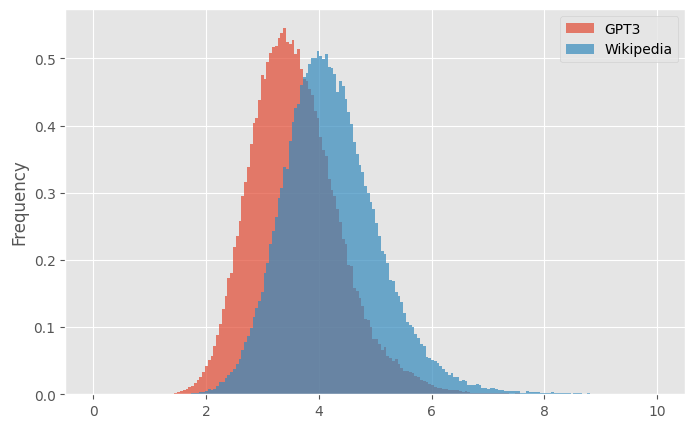

               mean    median       std      skew  kurtosis
author                                                     
GPT3       3.587309  3.513071  0.805960  0.891382  3.017990
Wikipedia  4.236547  4.156779  0.877577  0.873606  2.779184


In [214]:
from scipy.stats import norm
tt = np.linspace(0,10,203)
datar.groupby('author').response.plot.hist(bins = tt, density=True, alpha=.7, legend=True)
plt.savefig(f"Figs/{name}.png")
#plt.xlim((0,10))
plt.show()
#

def kurtosis(x):
    return scipy.stats.kurtosis(x)
agg_stats = datar.groupby('author').response.agg(['mean','median', 'std', 'skew', kurtosis])
print(agg_stats)

## Perplexity Vs. Length

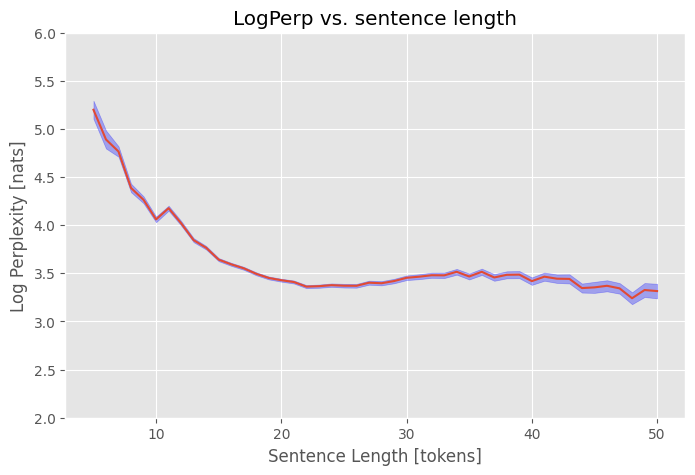

In [215]:
plot_perp_vs_len(datar[datar.author == machine_author], min_len=5, max_len=50)
plt.title("LogPerp vs. sentence length")
plt.ylim([2,6])
plt.savefig(f"Figs/logperp_vs_len_{name}.png")
plt.show()

 # Perplexity of first sentences vs. the rest

<Figure size 800x500 with 0 Axes>

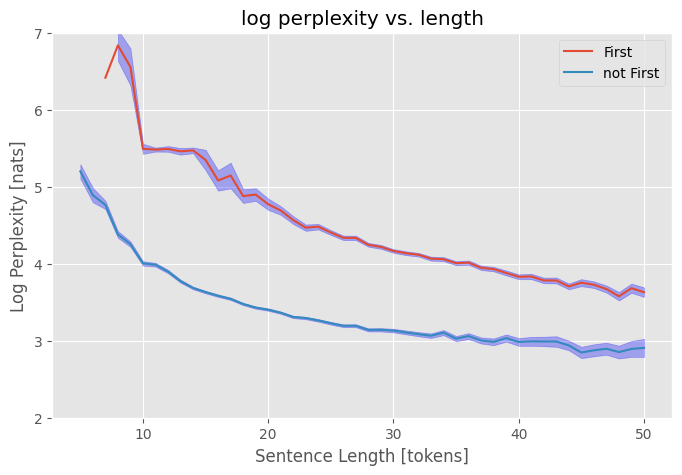

In [218]:
plt.figure()

min_len = 5
max_len = 50

data = datar[(datar.num == 1) & (datar.author == machine_author)]
df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

fig, ax = plt.subplots()
x = df_grouped['length']
ax.plot(x, df_grouped['mean'], label='First')
ax.fill_between(
    x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.3)

# second
data = datar[(datar.num != 1) & (datar.author == machine_author)]
df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

x = df_grouped['length']
ax.plot(x, df_grouped['mean'], label='not First')
ax.fill_between(
    x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.3)

ax.legend()
ax.set_ylim(ymin=0)


ax.set_title('log perplexity vs. length')
ax.set_xlabel("Sentence Length [tokens]")
ax.set_ylabel("Log Perplexity [nats]")
plt.rcParams["figure.figsize"] = (8,5)

plt.savefig(f"Figs/logperp_vs_len_first_sentence_{name}.png")
plt.ylim([2,7])
plt.show()

# ROC

In [219]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay
datas = datar[datar.num > 0]
fpr, tpr, thresholds = roc_curve(y_true=datas.author, y_score=datas.response, pos_label=human_author)

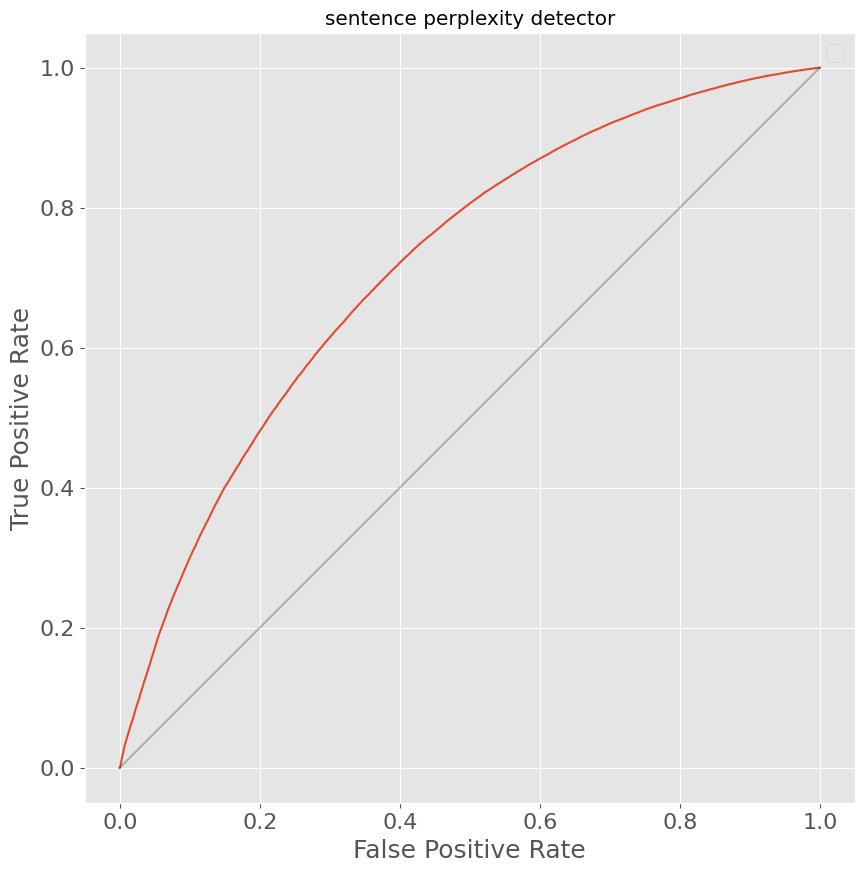

In [220]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot(label='logloss')
plt.plot([0, 1], [0, 1], "k", alpha=.25)
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)
plt.legend([],fontsize=16)
plt.title("sentence perplexity detector")
plt.savefig(f"Figs/ROC_sentences_{name}.png")
plt.show()

# Skewness and Kurtosis

In [221]:
def kurtosis(x):
    return scipy.stats.kurtosis(x)
agg_stats = datar.groupby('author').response.agg(['mean','median', 'std', 'skew', kurtosis])
print(agg_stats)

               mean    median       std      skew  kurtosis
author                                                     
GPT3       3.587309  3.513071  0.805960  0.891382  3.017990
Wikipedia  4.236547  4.156779  0.877577  0.873606  2.779184
